In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scikeras

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

In [6]:
from sklearn.model_selection import GridSearchCV,train_test_split
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam, RMSprop
from keras.layers import SimpleRNN, Dense, Dropout,BatchNormalization,LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [7]:
from sklearn.metrics import roc_curve, auc, roc_auc_score,f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [8]:
#df = pd.read_csv('waze_app_dataset.csv')
df = pd.read_csv('/content/drive/MyDrive/pre_process_waze.csv')

In [9]:
df.head(3)

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,...,km_per_drive,km_per_driving_day,drives_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,percent_of_sessions_to_favorite,device2,label2
0,retained,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,...,11.632058,138.360267,11.894737,0.953670,1,0.130381,79.430298,0.700931,0,0
1,retained,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,...,128.186173,1246.901868,9.727273,0.406856,0,0.266854,260.389902,0.253903,1,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,...,32.201567,382.393602,11.875000,0.841186,0,0.051121,113.953460,0.000000,0,0


In [10]:
df.shape

(14299, 22)

## Data PreProcessing

In [11]:
# Defining features and target variable
X = df.drop(columns=['label', 'label2', 'device'])

y = df['label2']


Balancing Data

In [12]:
# Apply SMOTE before splitting the data
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

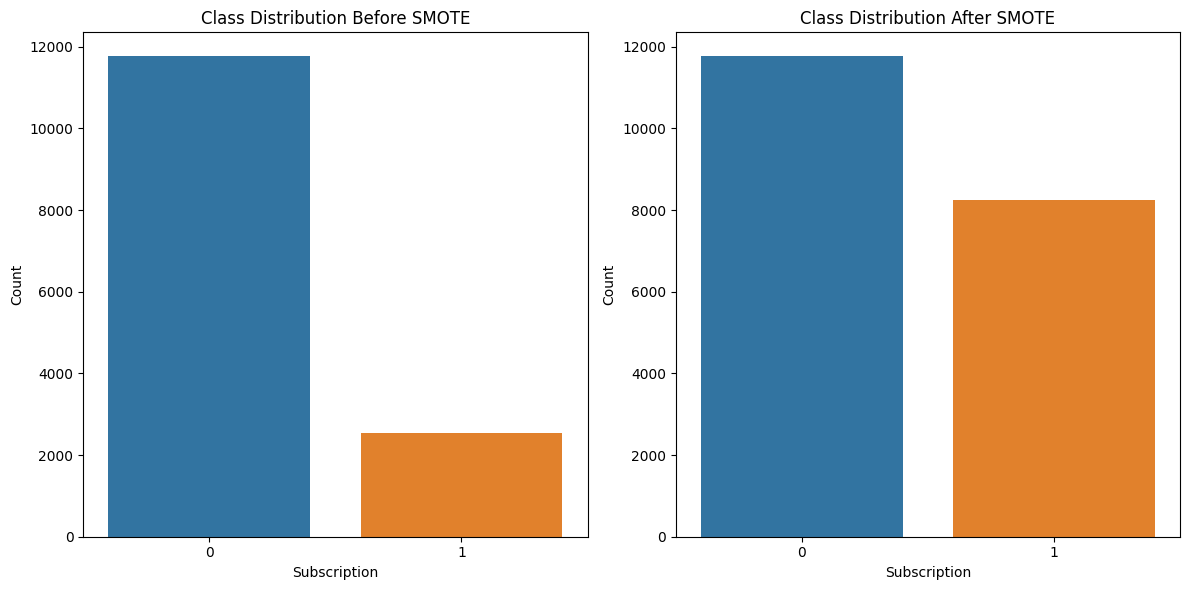

In [13]:
# Define custom colors for the labels
colors = ['#1f77b4', '#ff7f0e']  # Example: blue for 0, orange for 1

# Create a figure with 1 row and 2 columns for subplots
plt.figure(figsize=(12, 6))

# Plot the class distribution before SMOTE
plt.subplot(1, 2, 1)
sns.countplot(x=pd.Series(y), palette=colors)
plt.title("Class Distribution Before SMOTE")
plt.xlabel('Subscription')
plt.ylabel('Count')

# Plot the class distribution after SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=pd.Series(y_res), palette=colors)
plt.title("Class Distribution After SMOTE")
plt.xlabel('Subscription')
plt.ylabel('Count')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [15]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Deep Learning Models

**CNN**

In [16]:
model_cnn = Sequential()
# First Convolutional Layer
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model_cnn.add(BatchNormalization())  # Add batch normalization
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.3))
# Second Convolutional Layer
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.3))

model_cnn.add(Flatten())

# Dense Layers
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dropout(0.5))  # Dropout before final Dense layer
model_cnn.add(Dense(50, activation='relu'))  # Additional Dense layer

# Output Layer
model_cnn.add(Dense(1, activation='sigmoid'))

In [17]:
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 17, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 17, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 6, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          38,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,329 (270.82 KB)

 Trainable params: 68,945 (269.32 KB)

 Non-trainable params: 384 (1.50 KB)

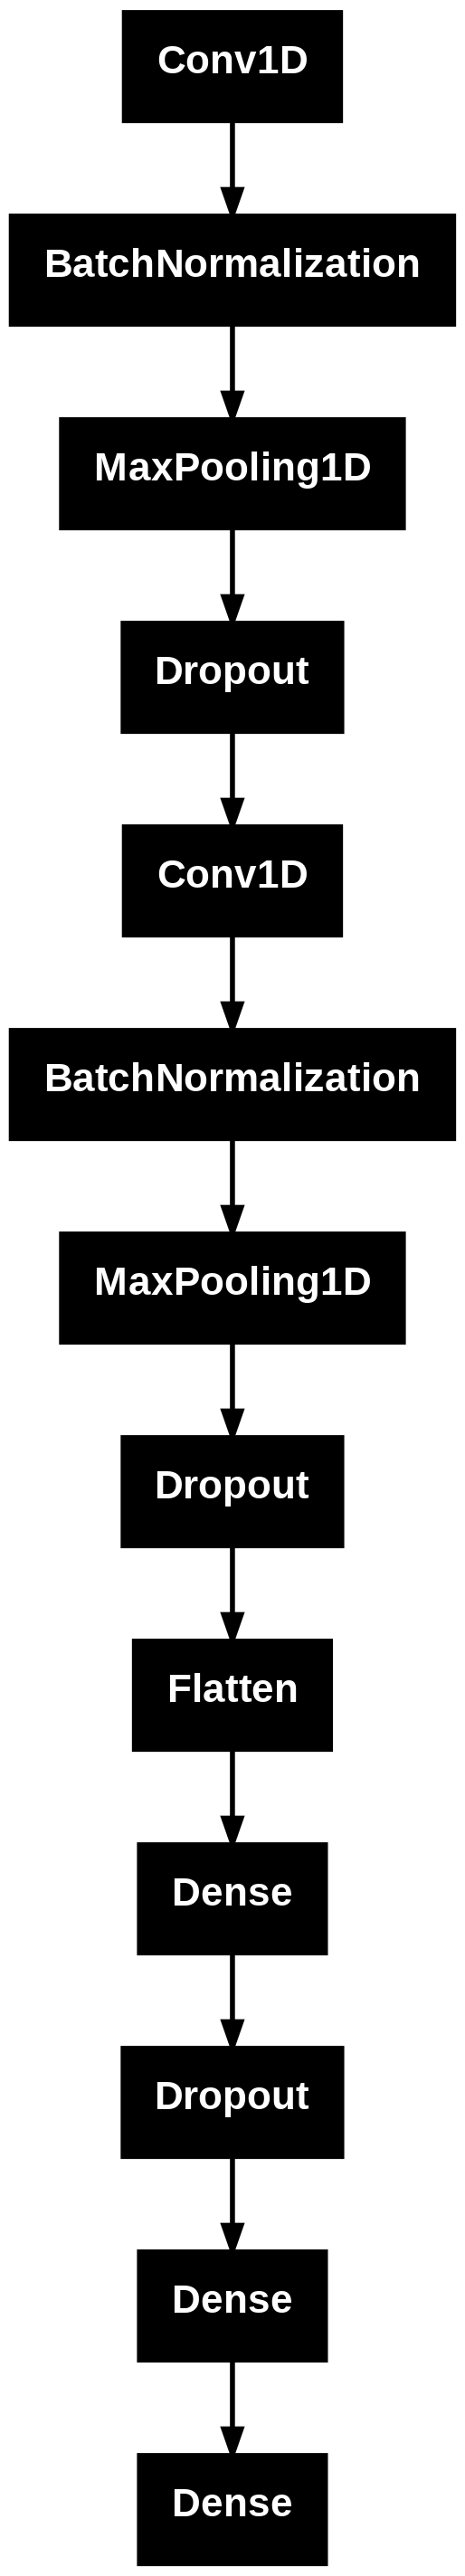

In [18]:
tf.keras.utils.plot_model(model_cnn)

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8)

history = model_cnn.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.6248 - loss: 0.6847 - val_accuracy: 0.6960 - val_loss: 0.5995
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6773 - loss: 0.5895 - val_accuracy: 0.7122 - val_loss: 0.5580
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6971 - loss: 0.5740 - val_accuracy: 0.7143 - val_loss: 0.5493
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6996 - loss: 0.5589 - val_accuracy: 0.7210 - val_loss: 0.5462
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7039 - loss: 0.5636 - val_accuracy: 0.7182 - val_loss: 0.5407
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7090 - loss: 0.5584 - val_accuracy: 0.7247 - val_loss: 0.5413
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7089 - loss: 0.5576 - val_accuracy: 0.7193 - val_loss: 0.5433
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7128 - loss: 0.5470 - val_a

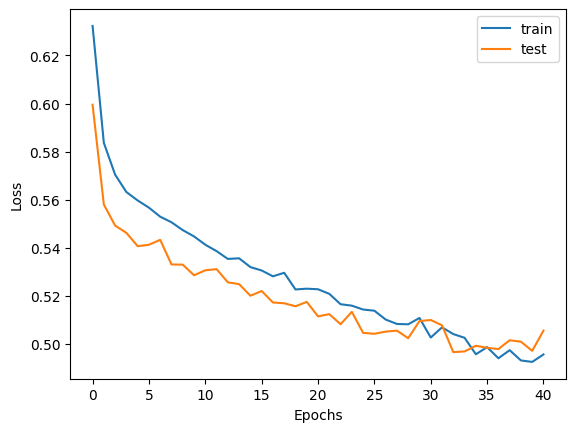

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

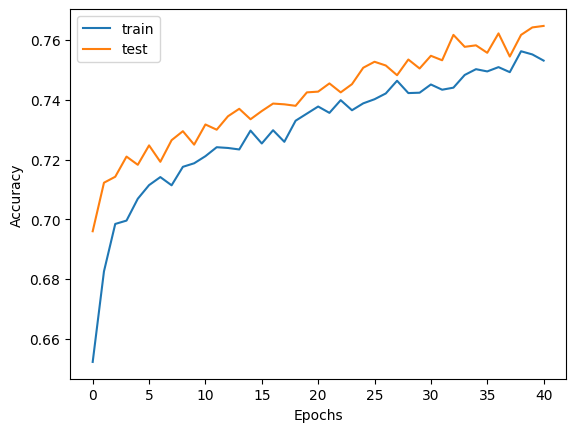

In [21]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
cnn_loss, cnn_acc = model_cnn.evaluate(X_test, y_test)
print(f"CNN Accuracy: {cnn_acc*100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7794 - loss: 0.4976
CNN Accuracy: 76.48%


In [23]:
# Generate predictions for CNN
y_pred_cnn = (model_cnn.predict(X_test) > 0.5).astype("int32")

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


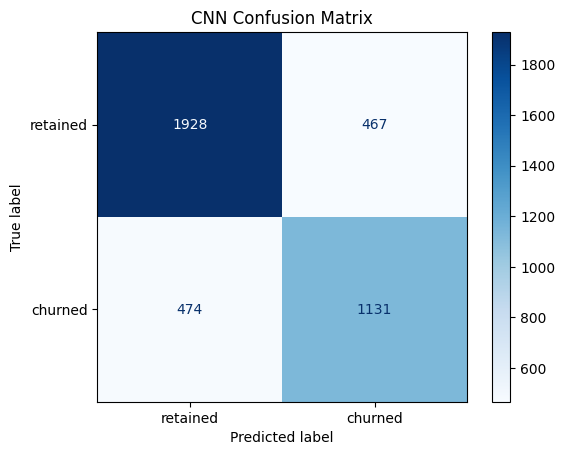

In [24]:
# CNN Confusion Matrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn,display_labels=['retained', 'churned'])
disp_cnn.plot(cmap=plt.cm.Blues)
plt.title("CNN Confusion Matrix")
plt.show()

**RNN** **Model**

In [25]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(100, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_rnn.add(Dropout(0.3))
model_rnn.add(SimpleRNN(50, activation='tanh'))
model_rnn.add(Dropout(0.3))
model_rnn.add(BatchNormalization())
model_rnn.add(Dense(50, activation='relu'))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
model_rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 19, 100)             │          10,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 19, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 50)                  │           7,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,551 (80.28 KB)

 Trainable params: 20,451 (79.89 KB)

 Non-trainable params: 100 (400.00 B)

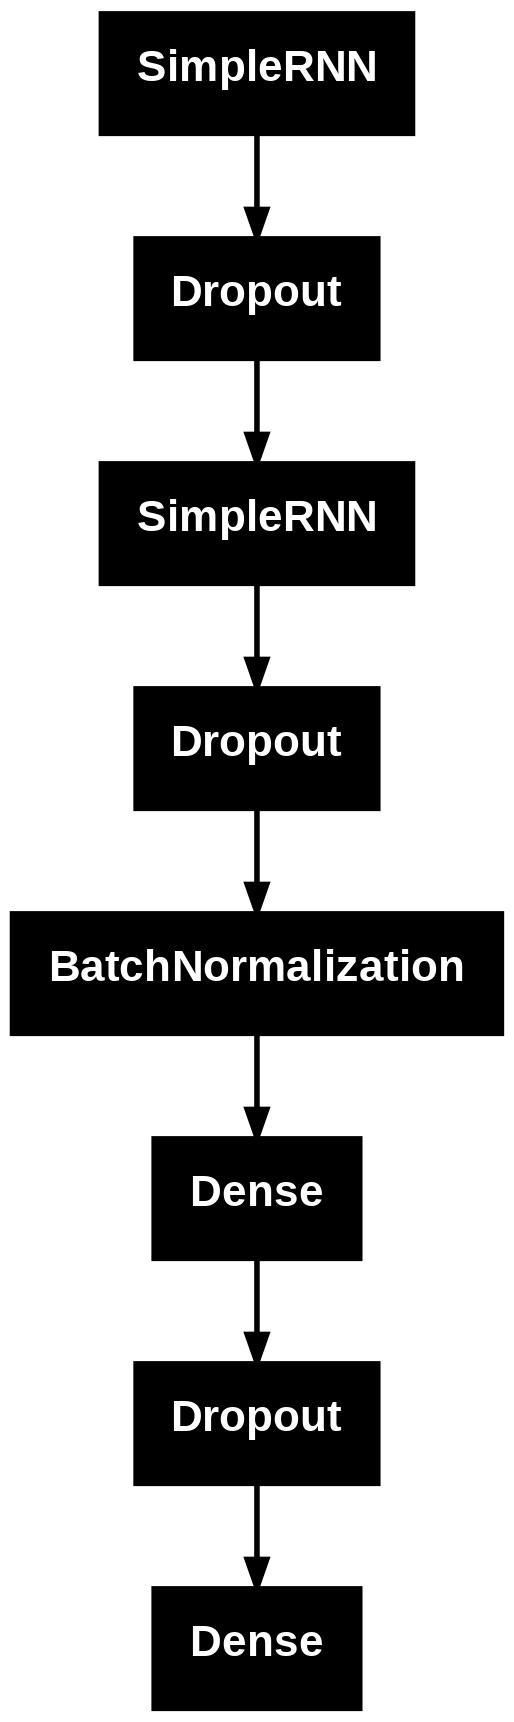

In [27]:
tf.keras.utils.plot_model(model_rnn)

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8)

history = model_rnn.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6568 - loss: 0.6337 - val_accuracy: 0.7095 - val_loss: 0.5532
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6798 - loss: 0.5847 - val_accuracy: 0.7072 - val_loss: 0.5505
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6985 - loss: 0.5701 - val_accuracy: 0.7197 - val_loss: 0.5445
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7003 - loss: 0.5688 - val_accuracy: 0.7163 - val_loss: 0.5508
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7117 - loss: 0.5574 - val_accuracy: 0.7180 - val_loss: 0.5434
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7139 - loss: 0.5574 - val_accuracy: 0.7300 - val_loss: 0.5352
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7129 - loss: 0.5549 - val_accuracy: 0.7232 - val_loss: 0.5422
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7210 - loss: 0.5493 - val_ac

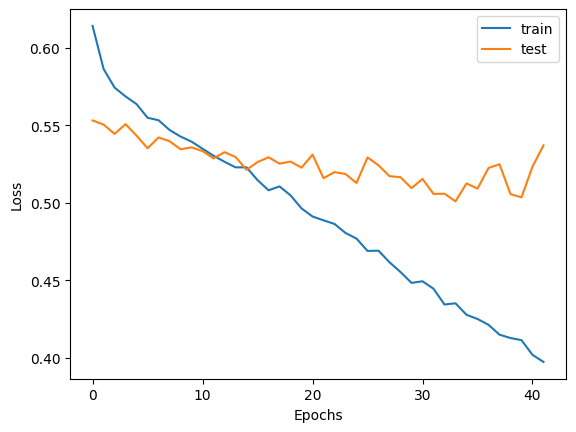

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

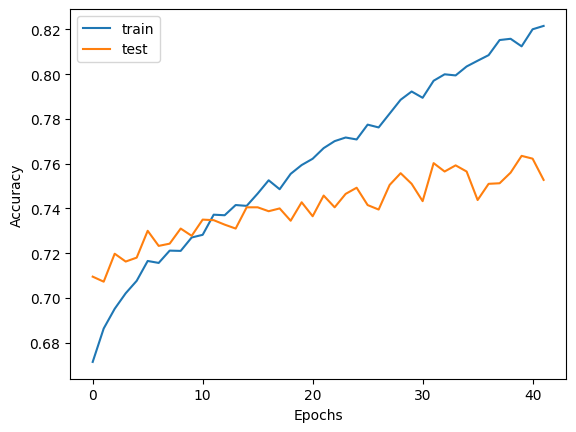

In [30]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
# Evaluate RNN
rnn_loss, rnn_acc = model_rnn.evaluate(X_test, y_test)
print(f"RNN Accuracy: {rnn_acc*100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7569 - loss: 0.5255
RNN Accuracy: 75.27%


In [32]:
# Generate predictions for RNN
y_pred_rnn = (model_rnn.predict(X_test) > 0.5).astype("int32")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


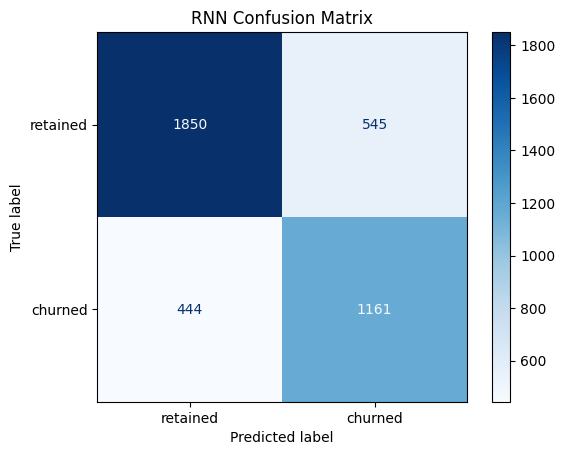

In [33]:
# RNN Confusion Matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
disp_rnn = ConfusionMatrixDisplay(confusion_matrix=cm_rnn,display_labels=['retained', 'churned'])
disp_rnn.plot(cmap=plt.cm.Blues)
plt.title("RNN Confusion Matrix")
plt.show()

**LSTM Model**

In [34]:
model_lstm = Sequential()
# Stacked LSTM Layers with Dropout
model_lstm.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(50, activation='relu'))
model_lstm.add(Dropout(0.3))

# Dense Layers
model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dropout(0.5))  # Dropout before final Dense layer
model_lstm.add(Dense(1, activation='sigmoid'))

In [35]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 19, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 19, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,601 (287.50 KB)

 Trainable params: 73,601 (287.50 KB)

 Non-trainable params: 0 (0.00 B)

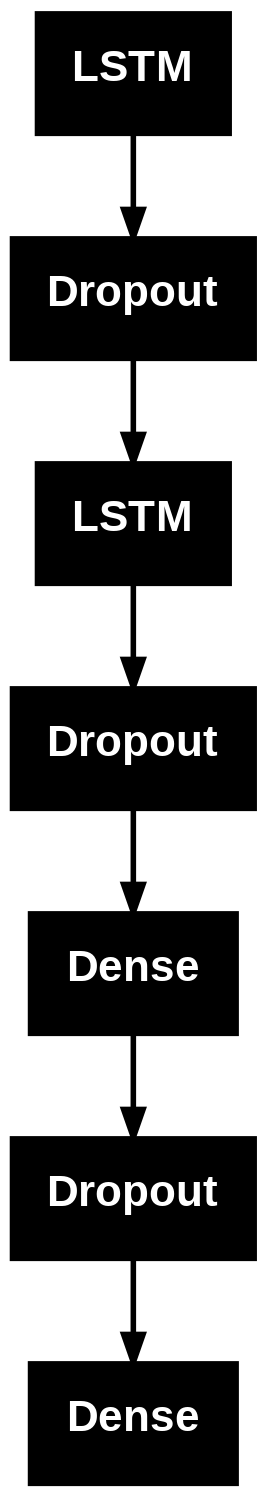

In [36]:
tf.keras.utils.plot_model(model_lstm)

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8)
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.5790 - loss: 0.6789 - val_accuracy: 0.5987 - val_loss: 0.6714
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5969 - loss: 0.6714 - val_accuracy: 0.6378 - val_loss: 0.6512
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6145 - loss: 0.6543 - val_accuracy: 0.6622 - val_loss: 0.6162
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6477 - loss: 0.6240 - val_accuracy: 0.6765 - val_loss: 0.5950
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6752 - loss: 0.6005 - val_accuracy: 0.6877 - val_loss: 0.5832
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6947 - loss: 0.5838 - val_accuracy: 0.6963 - val_loss: 0.5738
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6899 - loss: 0.5802 - val_accuracy: 0.7053 - val_loss: 0.5669
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6986 - loss: 0.5713 - val_a

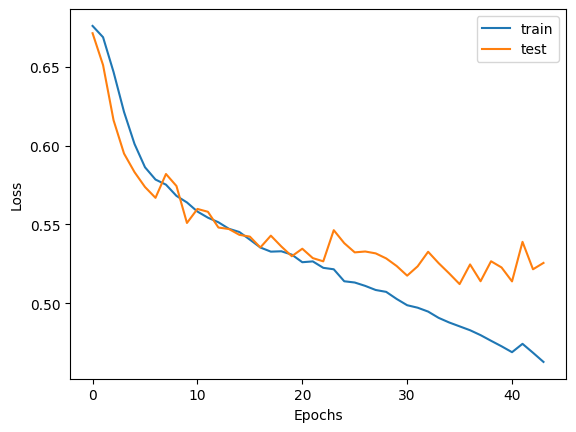

In [38]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

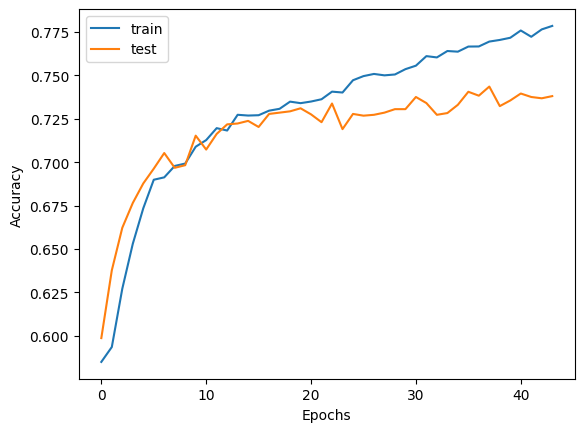

In [39]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
# Evaluate LSTM
lstm_loss, lstm_acc = model_lstm.evaluate(X_test, y_test)
print(f"LSTM Accuracy: {lstm_acc*100:.2f}%")


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7500 - loss: 0.5110
LSTM Accuracy: 73.80%


In [41]:
# Generate predictions for LSTM
y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype("int32")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


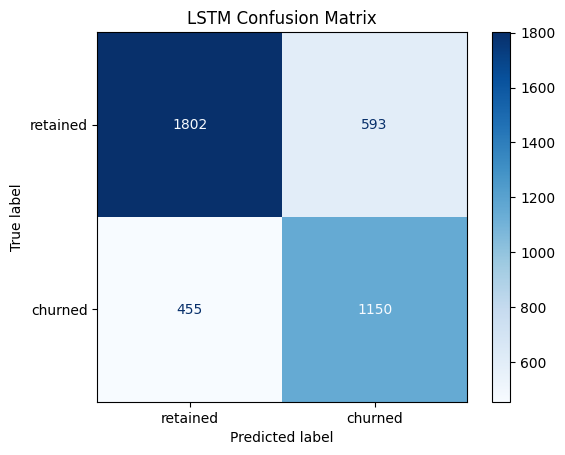

In [42]:
# LSTM Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm,display_labels=['retained', 'churned'])
disp_lstm.plot(cmap=plt.cm.Blues)
plt.title("LSTM Confusion Matrix")
plt.show()

**GRU Model**

In [43]:
model_gru = Sequential()

# Stacked GRU Layers with Dropout
model_gru.add(GRU(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(Dropout(0.3))
model_gru.add(GRU(50, activation='relu'))
model_gru.add(Dropout(0.3))

# Dense Layers
model_gru.add(Dense(50, activation='relu'))
model_gru.add(Dropout(0.5))  # Dropout before final Dense layer
model_gru.add(Dense(1, activation='sigmoid'))



In [44]:
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 19, 100)             │          30,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 19, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,301 (219.93 KB)

 Trainable params: 56,301 (219.93 KB)

 Non-trainable params: 0 (0.00 B)

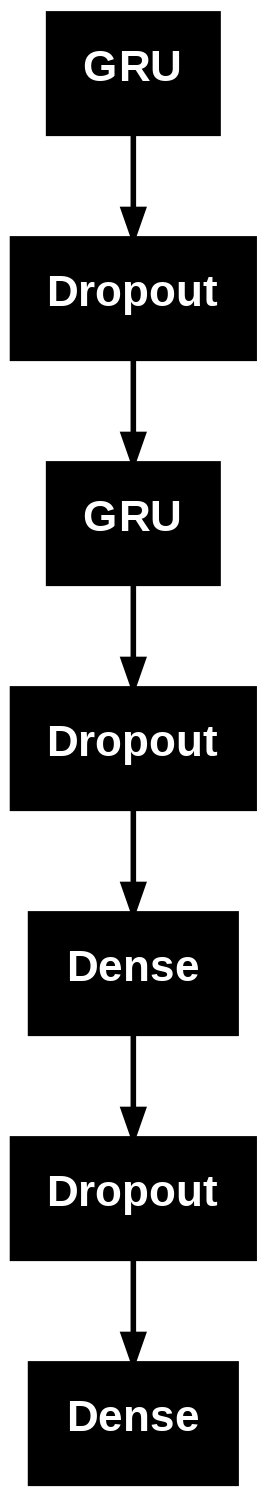

In [45]:
tf.keras.utils.plot_model(model_gru)

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8)

history = model_gru.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.5797 - loss: 0.6793 - val_accuracy: 0.6040 - val_loss: 0.6547
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6142 - loss: 0.6562 - val_accuracy: 0.6747 - val_loss: 0.6063
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6773 - loss: 0.6105 - val_accuracy: 0.6825 - val_loss: 0.5875
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6852 - loss: 0.5922 - val_accuracy: 0.6935 - val_loss: 0.5700
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6999 - loss: 0.5698 - val_accuracy: 0.7050 - val_loss: 0.5672
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7007 - loss: 0.5661 - val_accuracy: 0.7063 - val_loss: 0.5573
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7075 - loss: 0.5646 - val_accuracy: 0.7042 - val_loss: 0.5685
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7083 - loss: 0.5573 - val_

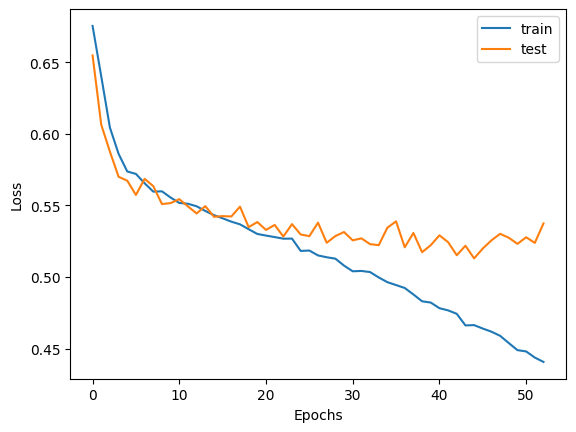

In [47]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

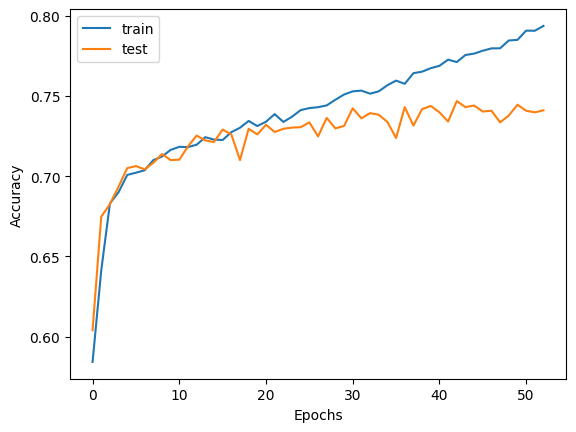

In [48]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
gru_loss, gru_acc = model_gru.evaluate(X_test, y_test)
print(f"GRU Accuracy: {gru_acc*100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7458 - loss: 0.5306
GRU Accuracy: 74.10%


In [50]:
# Generate predictions for GRU
y_pred_gru = (model_gru.predict(X_test) > 0.5).astype("int32")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


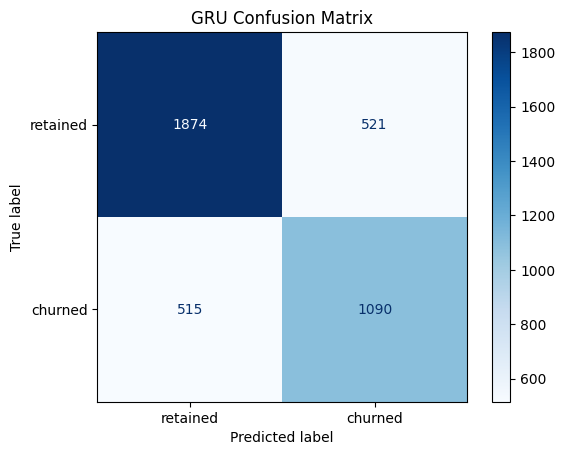

In [51]:
# GRU Confusion Matrix
cm_gru = confusion_matrix(y_test, y_pred_gru)
disp_gru = ConfusionMatrixDisplay(confusion_matrix=cm_gru,display_labels=['retained', 'churned'])
disp_gru.plot(cmap=plt.cm.Blues)
plt.title("GRU Confusion Matrix")
plt.show()

In [52]:
# Assuming y_test contains the true labels and y_pred_<model> contains the predictions from each model
metrics = {}
# Example for a CNN model:
metrics['CNN'] = {
    'Accuracy': accuracy_score(y_test, y_pred_cnn),
    'Precision': precision_score(y_test, y_pred_cnn),
    'Recall': recall_score(y_test, y_pred_cnn),
    'F1-Score': f1_score(y_test, y_pred_cnn),
    'AUC-ROC': roc_auc_score(y_test, y_pred_cnn)
}

# Repeat for other models
metrics['RNN'] = {
    'Accuracy': accuracy_score(y_test, y_pred_rnn),
    'Precision': precision_score(y_test, y_pred_rnn),
    'Recall': recall_score(y_test, y_pred_rnn),
    'F1-Score': f1_score(y_test, y_pred_rnn),
    'AUC-ROC': roc_auc_score(y_test, y_pred_rnn)
}

metrics['LSTM'] = {
    'Accuracy': accuracy_score(y_test, y_pred_lstm),
    'Precision': precision_score(y_test, y_pred_lstm),
    'Recall': recall_score(y_test, y_pred_lstm),
    'F1-Score': f1_score(y_test, y_pred_lstm),
    'AUC-ROC': roc_auc_score(y_test, y_pred_lstm)
}

metrics['GRU'] = {
    'Accuracy': accuracy_score(y_test, y_pred_gru),
    'Precision': precision_score(y_test, y_pred_gru),
    'Recall': recall_score(y_test, y_pred_gru),
    'F1-Score': f1_score(y_test, y_pred_gru),
    'AUC-ROC': roc_auc_score(y_test, y_pred_gru)
}


In [53]:
# Convert the metrics dictionary into a DataFrame ACTUALESSS
metrics_df = pd.DataFrame(metrics).T  # Transpose to have models as rows

# Display the table
print(metrics_df)

      Accuracy  Precision    Recall  F1-Score   AUC-ROC
CNN    0.76475   0.707760  0.704673  0.706213  0.754842
RNN    0.75275   0.680539  0.723364  0.701299  0.747904
LSTM   0.73800   0.659782  0.716511  0.686977  0.734456
GRU    0.74100   0.676598  0.679128  0.677861  0.730796


In [54]:
# Assuming y_test contains the true labels and y_pred_prob_<model> contains the predicted probabilities from each model

# ROC Curve and AUC for CNN
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# ROC Curve and AUC for RNN
fpr_rnn, tpr_rnn, _ = roc_curve(y_test, y_pred_rnn)
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

# ROC Curve and AUC for LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# ROC Curve and AUC for GRU
fpr_gru, tpr_gru, _ = roc_curve(y_test, y_pred_gru)
roc_auc_gru = auc(fpr_gru, tpr_gru)


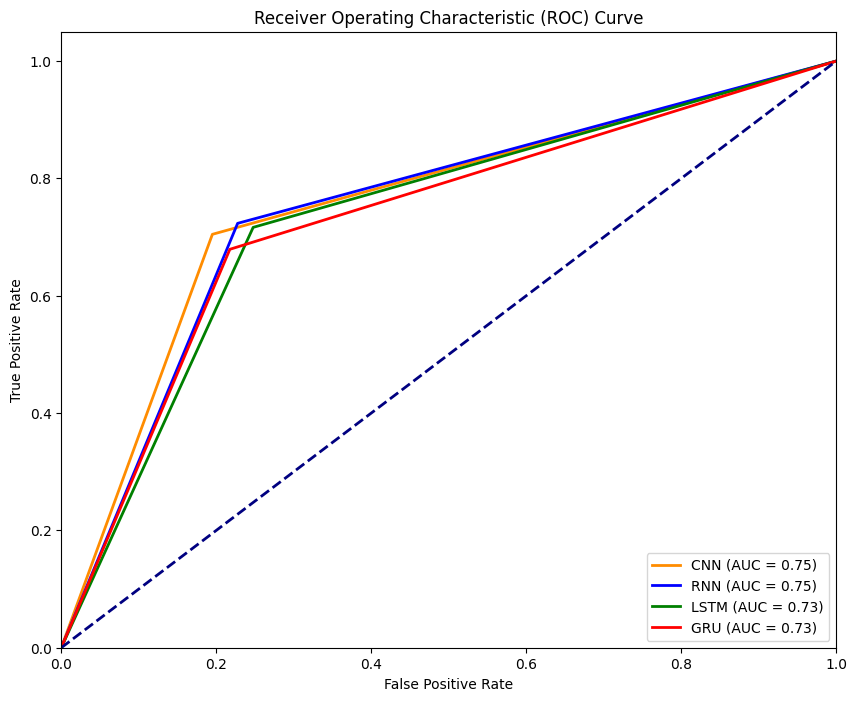

In [55]:
# Plot ROC curve for each model
plt.figure(figsize=(10, 8))

plt.plot(fpr_cnn, tpr_cnn, color='darkorange', lw=2, label=f'CNN (AUC = {roc_auc_cnn:.2f})')
plt.plot(fpr_rnn, tpr_rnn, color='blue', lw=2, label=f'RNN (AUC = {roc_auc_rnn:.2f})')
plt.plot(fpr_lstm, tpr_lstm, color='green', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_gru, tpr_gru, color='red', lw=2, label=f'GRU (AUC = {roc_auc_gru:.2f})')

# Plot the diagonal line (random guessing)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.show()
